In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

In [ ]:
# Given pre-processing code (https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py)

import cv2
import imutils

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from tqdm import tqdm

data_path = '/content/drive/MyDrive/COMP562_Project/data'
IMG_SIZE = 224
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# for class_name in tqdm(class_names, position=0):
#   class_path = data_path + '/unprocessed/train/' + class_name
#   save_path = data_path + '/processed/train/' + class_name
#   for img_name in tqdm(os.listdir(class_path), position=0):
#     img_path = os.path.join(class_path, img_name)
#     img = cv2.imread(img_path)
#     img = crop_img(img)
#     img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
#     if not os.path.exists(save_path):
#       os.makedirs(save_path)
#     cv2.imwrite(save_path + '/' + img_name, img)

# for class_name in tqdm(class_names, position=0):
#   class_path = data_path + '/unprocessed/test/' + class_name
#   save_path = data_path + '/processed/test/' + class_name
#   for img_name in tqdm(os.listdir(class_path), position=0):
#     img_path = os.path.join(class_path, img_name)
#     img = cv2.imread(img_path)
#     img = crop_img(img)
#     img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
#     if not os.path.exists(save_path):
#       os.makedirs(save_path)
#     cv2.imwrite(save_path + '/' + img_name, img)

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/COMP562_Project/data/processed/train",
  labels="inferred",
  label_mode="int", # glioma = 0, meningioma = 1, notumor = 2, pituitary = 3
  color_mode="grayscale",
  image_size=(224, 224),
  batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/COMP562_Project/data/processed/test",
  labels="inferred",
  label_mode="int", # glioma = 0, meningioma = 1, notumor = 2, pituitary = 3
  color_mode="grayscale",
  image_size=(224, 224),
  batch_size=32
)

Found 5715 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

In [ ]:
flattened_train_ds = train_ds.unbatch().map(normalize_img).cache()
flattened_test_ds = test_ds.unbatch().map(normalize_img).cache()

In [ ]:
import itertools

# Generate all possible 2-train, 2-test class splits
all_splits = []
for train_classes in itertools.combinations(class_names, 2):
    test_classes = [c for c in class_names if c not in train_classes]
    all_splits.append((train_classes, tuple(test_classes)))

print("Generated splits:")
for idx, (train_split, test_split) in enumerate(all_splits):
    print(f"Split {idx+1}: Train on {train_split}, Test on {test_split}")

Generated splits:
Split 1: Train on ('glioma', 'meningioma'), Test on ('notumor', 'pituitary')
Split 2: Train on ('glioma', 'notumor'), Test on ('meningioma', 'pituitary')
Split 3: Train on ('glioma', 'pituitary'), Test on ('meningioma', 'notumor')
Split 4: Train on ('meningioma', 'notumor'), Test on ('glioma', 'pituitary')
Split 5: Train on ('meningioma', 'pituitary'), Test on ('glioma', 'notumor')
Split 6: Train on ('notumor', 'pituitary'), Test on ('glioma', 'meningioma')


In [ ]:
def filter_dataset_by_class(dataset, selected_class_names, class_names):
    class_name_to_label = {name: i for i, name in enumerate(selected_class_names)}
    filtered_imgs = []
    filtered_labels = []

    for img, label in dataset.as_numpy_iterator():
        label_str = class_names[label]
        if label_str in selected_class_names:
            filtered_imgs.append(img)
            filtered_labels.append(class_name_to_label[label_str])

    ds = tf.data.Dataset.from_tensor_slices((np.stack(filtered_imgs), np.array(filtered_labels)))
    return ds

In [ ]:
def make_siamese_pair_dataset(dataset, num_pairs=20000):
    label_to_images = {}

    # Organize images by label
    for img, label in dataset.as_numpy_iterator():
        label = int(label)
        if label not in label_to_images:
            label_to_images[label] = []
        label_to_images[label].append(img)

    labels = list(label_to_images.keys())

    def generator():
        for _ in range(num_pairs):
            # Positive pair: two images from the same class
            label = np.random.choice(labels)
            imgs = np.random.choice(len(label_to_images[label]), 2, replace=False)
            img1 = label_to_images[label][imgs[0]]
            img2 = label_to_images[label][imgs[1]]
            yield (img1, img2), 1

            # Negative pair: two images from different classes
            label1, label2 = np.random.choice(labels, 2, replace=False)
            img1 = label_to_images[label1][np.random.choice(len(label_to_images[label1]))]
            img2 = label_to_images[label2][np.random.choice(len(label_to_images[label2]))]
            yield (img1, img2), 0

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
             tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32)),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

In [ ]:
from tensorflow.keras import layers, Model, Input

def create_base_network(input_shape=(224, 224, 1)):
    input = Input(shape=input_shape)

    x = layers.Conv2D(32, (7,7), activation='relu', padding='same')(input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(64, (5,5), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    return Model(input, x)

In [ ]:
def create_siamese_model(input_shape=(224, 224, 1)):

    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    feat_a = base_network(input_a)
    feat_b = base_network(input_b)

    merged = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat_a, feat_b])

    x = layers.Dense(128, activation='relu')(merged)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # sigmoid → probability

    return Model(inputs=[input_a, input_b], outputs=x)

In [ ]:
def create_few_shot_episode(dataset, n_way=2, k_shot=5, q_query=5):
    label_to_images = {}
    for img, label in dataset.as_numpy_iterator():
        label = int(label)
        if label not in label_to_images:
            label_to_images[label] = []
        label_to_images[label].append(img)

    selected_labels = np.random.choice(list(label_to_images.keys()), size=n_way, replace=False)

    support_imgs, support_lbls = [], []
    query_imgs, query_lbls = [], []

    for i, label in enumerate(selected_labels):
        imgs = np.random.choice(len(label_to_images[label]), size=k_shot + q_query, replace=False)
        support = imgs[:k_shot]
        query = imgs[k_shot:]

        for idx in support:
            support_imgs.append(label_to_images[label][idx])
            support_lbls.append(i)

        for idx in query:
            query_imgs.append(label_to_images[label][idx])
            query_lbls.append(i)

    return (np.stack(support_imgs), np.array(support_lbls),
            np.stack(query_imgs), np.array(query_lbls))

In [ ]:
def few_shot_predict(model, support_imgs, support_lbls, query_imgs):
    predictions = []

    for q in query_imgs:
        sims = []
        for s in support_imgs:
            q_batch = tf.expand_dims(q, axis=0)
            s_batch = tf.expand_dims(s, axis=0)
            sim = model.predict([q_batch, s_batch], verbose=0)[0][0]
            sims.append(sim)
        best = np.argmax(sims)
        predictions.append(support_lbls[best])

    return np.array(predictions)


Split 1: Train on ('glioma', 'meningioma') | Evaluate on ('notumor', 'pituitary')
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 111s 100ms/step - accuracy: 0.6045 - loss: 0.6566
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.7517 - loss: 0.5139
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.8801 - loss: 0.3052
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.9533 - loss: 0.1355
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.9862 - loss: 0.0407
Split 1 Few-Shot Accuracy: 0.6080 ± 0.1501

Split 2: Train on ('glioma', 'notumor') | Evaluate on ('meningioma', 'pituitary')
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 106s 102ms/step - accuracy: 0.8735 - loss: 0.2953
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accuracy: 0.9811 - loss: 0.0582
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.9928 - loss: 0.0220
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 102ms/step - accu

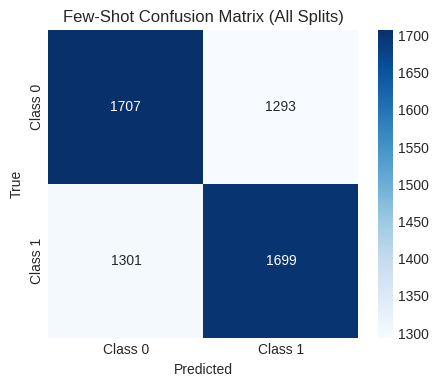

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results = []
all_preds = []
all_labels = []

for split_idx, (train_classes, test_classes) in enumerate(all_splits):
    print(f"\nSplit {split_idx+1}: Train on {train_classes} | Evaluate on {test_classes}")

    # Filter datasets by split
    train_data = filter_dataset_by_class(flattened_train_ds, train_classes, class_names)
    test_data = filter_dataset_by_class(flattened_test_ds, test_classes, class_names)

    # Pair training data
    train_pairs = make_siamese_pair_dataset(train_data).repeat().batch(32).prefetch(tf.data.AUTOTUNE)

    # Create model
    model = create_siamese_model()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train only on meta-train classes
    model.fit(train_pairs, steps_per_epoch=1000, epochs=5, verbose=1)

    # Few-shot evaluation on meta-test classes
    accs = []
    split_preds = []
    split_labels = []

    for _ in range(100):  # 100 episodes
        support_imgs, support_lbls, query_imgs, query_lbls = create_few_shot_episode(
            test_data, n_way=2, k_shot=5, q_query=5
        )
        preds = few_shot_predict(model, support_imgs, support_lbls, query_imgs)

        acc = np.mean(preds == query_lbls)
        accs.append(acc)

        split_preds.extend(preds)
        split_labels.extend(query_lbls)

    avg = np.mean(accs)
    std = np.std(accs)

    print(f"Split {split_idx+1} Few-Shot Accuracy: {avg:.4f} ± {std:.4f}")
    results.append(avg)
    all_preds.extend(split_preds)
    all_labels.extend(split_labels)

# Print overall performance
print("\n=== Cross-Split Summary ===")
print(f"Avg Accuracy: {np.mean(results):.4f} ± {np.std(results):.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Few-Shot Confusion Matrix (All Splits)")
plt.show()